Author: Olha Maslova <br>
Data Source: http://insideairbnb.com/get-the-data.html<br>
Data Set: Detailed Listings data for New York City<br>
Data Collected: April 7th, 2021<br>
Date Created: June 18th, 2021

<h3>Problem trying to solve:</h3> Can I use data to help new and existing hosts on Airbnb improve their listings and ensure their accounts and listing are more appealing to guests, and consequently, are more competitive? <br>

<h3> Questions:</h3>
1. What is word difference between listing titles in the two groups? Should you use all capitals in your title?<br>
2. What is word difference between listing descriptions in the two groups? Neighborhood overviews?<br>
3. How do Amenities differ in the two groups?<br>
4. What is word difference between host sections in the two groups? <br>
5. What can we learn from guest reviews?<br>

<h1><center>Initial set up</center></h1>

## Import

In [1]:
import re
import importlib

from wordcloud import STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import nltk

import lib
from lib import label_each_bar, get_rid_of_spine, \
    update_tf_to_bool, get_top_words, get_diff, remove_count, \
    create_dummy_df, parse_missing_col_values, sentiment_analysis

importlib.reload(lib)

# Initial set-up
sns.set_style('whitegrid')
stopwords = set(STOPWORDS)
stopwords.update(['br', 'b', '<br>', '</br>'])

## Data Understanding

For this project, I used the Inside Airbnb website's detailed NYC listings data compiled on April 7th, 2021. This dataset contains 36905 listings with 74 columns (the way data scientists call them — features). These features include title, description, price, amenities, location of a rented property, and host information such as name, ranking, about, number of listings, location, etc. 

In [2]:
# read the data
new_york_listings_2021 = pd.read_csv("../data/listings-detailed.csv")

# check if data loaded correctly
new_york_listings_2021.head(3)

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2595,https://www.airbnb.com/rooms/2595,20210407173759,2021-04-09,Skylit Midtown Castle,"Beautiful, spacious skylit studio in the heart...",Centrally located in the heart of Manhattan ju...,https://a0.muscache.com/pictures/f0813a11-40b2...,2845,https://www.airbnb.com/users/show/2845,...,10.0,10.0,9.0,NaN,f,3,3,0,0,0.35
1,3831,https://www.airbnb.com/rooms/3831,20210407173759,2021-04-12,"Whole flr w/private bdrm, bath & kitchen(pls r...","Enjoy 500 s.f. top floor in 1899 brownstone, w...",Just the right mix of urban center and local n...,https://a0.muscache.com/pictures/e49999c2-9fd5...,4869,https://www.airbnb.com/users/show/4869,...,10.0,10.0,10.0,NaN,f,1,1,0,0,4.98
2,5121,https://www.airbnb.com/rooms/5121,20210407173759,2021-04-09,BlissArtsSpace!,<b>The space</b><br />HELLO EVERYONE AND THANK...,NaN,https://a0.muscache.com/pictures/2090980c-b68e...,7356,https://www.airbnb.com/users/show/7356,...,10.0,9.0,9.0,NaN,f,1,0,1,0,0.35


In [3]:
# get the shape of the data
new_york_listings_2021.shape

(36905, 74)

In [4]:
new_york_listings_2021.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,3.690500e+04,3.690500e+04,3.690500e+04,35637.000000,35637.000000,36905.000000,36905.000000,36905.000000,0.0,33231.000000,...,26461.000000,26474.000000,26460.000000,26460.000000,0.0,36905.000000,36905.000000,36905.000000,36905.000000,27185.000000
mean,2.578128e+07,2.021041e+13,9.847262e+07,28.464293,28.464293,40.729395,-73.950308,2.791898,NaN,1.318137,...,9.713503,9.706089,9.594747,9.364928,NaN,11.071318,5.789243,5.108874,0.088497,0.854783
std,1.552860e+07,9.843883e-01,1.145377e+08,181.069747,181.069747,0.054947,0.048829,1.861854,NaN,0.716233,...,0.843701,0.871186,0.810880,1.029778,NaN,36.699390,27.007089,22.482685,1.093764,1.349439
min,2.595000e+03,2.021041e+13,2.438000e+03,0.000000,0.000000,40.508630,-74.241350,0.000000,NaN,1.000000,...,2.000000,2.000000,2.000000,2.000000,NaN,1.000000,0.000000,0.000000,0.000000,0.010000
25%,1.154465e+07,2.021041e+13,1.010236e+07,1.000000,1.000000,40.690080,-73.983510,2.000000,NaN,1.000000,...,10.000000,10.000000,9.000000,9.000000,NaN,1.000000,0.000000,0.000000,0.000000,0.100000
50%,2.593975e+07,2.021041e+13,4.267652e+07,1.000000,1.000000,40.725300,-73.955280,2.000000,NaN,1.000000,...,10.000000,10.000000,10.000000,10.000000,NaN,1.000000,1.000000,1.000000,0.000000,0.340000
75%,4.067650e+07,2.021041e+13,1.613001e+08,3.000000,3.000000,40.762320,-73.932450,4.000000,NaN,1.000000,...,10.000000,10.000000,10.000000,10.000000,NaN,3.000000,1.000000,1.000000,0.000000,1.090000
max,4.909253e+07,2.021041e+13,3.958177e+08,2844.000000,2844.000000,40.917140,-73.710870,16.000000,NaN,14.000000,...,10.000000,10.000000,10.000000,10.000000,NaN,266.000000,266.000000,199.000000,31.000000,47.600000


<h1><center>Aproach</center></h1>

    
After cleaning the data, I had to choose how to define successful hosts or role models. The two approaches I considered were:
- Compare super hosts to everyone else.
- Use quantiles to get the top 25% of listings based on guest rating and compare them to the remaining 75%. 

The two approaches are similar. However, super host status requires a host to meet specific criteria such as:
- Completed at least 10 trips OR completed 3 reservations that total at least 100 nights
- Maintained a 90% response rate or higher
- Maintained a 1% percent cancellation rate
- Maintained a 4.8 overall rating (this rating looks at the past 365 days of reviews, based on the date the guest left a review, not the date the guest checked out)

While maintaining a high response rate and low cancellation rate is critical for all hosts to be competitive on the platform, I will focus solely on hosts' ratings in this analysis. In other words, I will pursue the second approach, keeping the restriction on the minimum number of reservations for the top group.
Two groups of hosts: 

**Group 1:** Top 25% of hosts in New York with the minimum of 3 reservations; <br>
**Group 2:** Remaining 75% of hosts in New York;<br>

<h1><center>Data Preprocessing Using Pandas and Numpy</center></h1>

In this project, I will focus on the following information:
1. Reviews
2. Listing title
3. Listing description
4. Amenities
5. Host bio

## Reviews

In [5]:
review_col = ['review_scores_accuracy',
              'review_scores_checkin',
              'review_scores_value',
              'review_scores_communication',
              'review_scores_cleanliness',
              'review_scores_rating'
             ]
# check the data type (should be float or int)
for col in review_col:
    print(new_york_listings_2021[col].dtype)

float64
float64
float64
float64
float64
float64


In [6]:
# check how many missing values are there in each column
for col in review_col:
    print(np.sum(new_york_listings_2021[col].isna()))

10434
10444
10445
10431
10423
10409


I am mostly concerned about missing values in *review_scores_rating* column because this is how I am going to split my data - based on reviews. Let's try to see why there are no reviews.

In [7]:
no_reviews_df = new_york_listings_2021[new_york_listings_2021['review_scores_rating'].isna()]
no_reviews_df.sort_values(by='host_since').head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
17407,23669201,https://www.airbnb.com/rooms/23669201,20210407173759,2021-04-08,Great Price: Williamsburg Brooklyn Loft off L ...,"1,100 sq. ft Loft between Williamsburg and Bu...",Old Italian neighborhood that is now gentrifie...,https://a0.muscache.com/pictures/44ffd47c-68a8...,2438,https://www.airbnb.com/users/show/2438,...,NaN,NaN,NaN,NaN,f,1,1,0,0,0.03
30532,43679750,https://www.airbnb.com/rooms/43679750,20210407173759,2021-04-10,Trilevel Brooklyn Townhome,Four bedroom house<br /><br /><b>Other things ...,Quiet and close to conveniences,https://a0.muscache.com/pictures/67753acb-4ff2...,2787,https://www.airbnb.com/users/show/2787,...,NaN,NaN,NaN,NaN,f,8,1,5,2,NaN
30413,43564916,https://www.airbnb.com/rooms/43564916,20210407173759,2021-04-10,"Sweet Spot - Calm, Clean, Comfy, Accessible","This clean, calming, safe, sanctuary is tucked...","The East 60s have a calming, subdued vibe—but ...",https://a0.muscache.com/pictures/dc6bdbba-1c54...,2782,https://www.airbnb.com/users/show/2782,...,NaN,NaN,NaN,NaN,f,3,1,2,0,NaN
36861,49059730,https://www.airbnb.com/rooms/49059730,20210407173759,2021-04-09,Skylit Midtown Sanctuary,"Beautiful, spacious studio in the heart of Mid...",NaN,https://a0.muscache.com/pictures/f0813a11-40b2...,2845,https://www.airbnb.com/users/show/2845,...,NaN,NaN,NaN,NaN,f,3,3,0,0,NaN
34045,46931266,https://www.airbnb.com/rooms/46931266,20210407173759,2021-04-11,Sunny Tribeca penthouse loft ideal for home of...,NaN,NaN,https://a0.muscache.com/pictures/2a5f0d7d-787d...,3757,https://www.airbnb.com/users/show/3757,...,NaN,NaN,NaN,NaN,t,1,1,0,0,NaN


I don't see any anomalies in the data. It seems that some of the hosts are new to the platform, others just don't have any reviews. So in order to avoid Nan in the dataset, I will substitute it with zeros.

In [8]:
# fill review columns with 0s
for col in review_col:
    new_york_listings_2021[col] = new_york_listings_2021[col].fillna(0)
    print(np.sum(new_york_listings_2021[col].isna()))

0
0
0
0
0
0


## Further Dealing with Missing Data In Title, Description, Neighborhood  description, Host bio 
For each of the following columns we want to create a feature that will represent a presence of missing data.

In [9]:
text_cols = ['name', 'description', 'host_about', 'neighborhood_overview']

# print the number of missing values in each column
for col in text_cols:
    print(col, new_york_listings_2021[new_york_listings_2021[col].isnull() == True].shape[0])

name 13
description 1268
host_about 15662
neighborhood_overview 13818


In [10]:
for col in text_cols:
    new_york_listings_2021 = parse_missing_col_values(new_york_listings_2021, col)

Success!
Success!
Success!
Success!


## Dealing with Text Data

- name
- description
- neighborhood_overview
- host_about

#### The question is what kind of features can we extract and how can we do it?
One of the simpliest aproaches is to run a sentiment analysis on these column and see if the text is positive/negative/neutural. For the name column, I also want to create a boolean  feature **is_all_caps** to mark columns that are written in all capitals.

In [11]:
# create a dummy variable for all caps in the name column
new_york_listings_2021['name_is_all_caps'] = 0
new_york_listings_2021.loc[new_york_listings_2021['name'].str.isupper(), 'name_is_all_caps'] = 1
np.sum(new_york_listings_2021['name_is_all_caps'])

1111

In [12]:
# sentiment analysis of text columns
for col in text_cols:
    new_york_listings_2021 = sentiment_analysis(new_york_listings_2021, col)

# check the result  
new_york_listings_2021.description_score[:20]

0      (0.32796883116883124, 0.5910961038961039)
1        (0.1708333333333333, 0.515277777777778)
2      (0.17452380952380953, 0.4838095238095238)
3                    (0.2703030303030303, 0.495)
4      (0.13084415584415587, 0.3025974025974026)
5       (0.22664285714285715, 0.502904761904762)
6       (0.40545977011494244, 0.606431308155446)
7       (0.2609625668449198, 0.5791889483065953)
8      (0.2833333333333333, 0.49049857549857545)
9      (0.27499999999999997, 0.5657407407407408)
10     (0.21696969696969698, 0.4166666666666667)
11     (0.21624649859943978, 0.3893557422969187)
12    (0.27802197802197803, 0.41758241758241754)
13     (0.18356643356643357, 0.4432067932067932)
14      (0.10649350649350649, 0.428728354978355)
15      (0.3174095796676441, 0.5457380254154448)
16      (0.2942857142857143, 0.5452380952380952)
17      (0.2946991341991342, 0.5019891774891775)
18       (0.4142473118279569, 0.589247311827957)
19    (0.10238095238095239, 0.34781746031746036)
Name: description_sc

We also need to update the type of **host_is_superhost** from string ('t/f') to boolean 1/0.

In [13]:
new_york_listings_2021 = update_tf_to_bool(new_york_listings_2021, ['host_is_superhost'])

## Dealing with Categorical Data

#### Amenities

Values in **amenities** column are strings that look like a list of amenities. It won't be easy to work with such a format. Since this is a categorical variable, we can create a dummy variable for each option in the list and drop the original column. This approach will allow us to see what amenities are included at each place.

In [14]:
# check the column type
new_york_listings_2021.amenities.dtype

dtype('O')

In [15]:
# create a set of amenities
amenities = set()

# get a list of all values in the column
amenities_list = new_york_listings_2021.amenities.tolist()

for listing in amenities_list:
    # clean up the string
    listing = listing.replace('[', '').replace(']', '').replace('\\u2019', "'").replace('\\u2013', " ")
    # split the string into the individual amenities
    listing = listing.split('", ')
    
    # add each amenity to the set
    for amenity in listing:
        amenity = amenity.replace('"', '')
        amenities.add(amenity)

# see the result
len(amenities)

1063

In [16]:
# Sample amenities
list(amenities)[:10]

['',
 "Kiehl's  shampoo",
 'electric  stainless steel oven',
 '50\\ HDTV with Netflix',
 'Clothing storage: walk-in closet and dresser',
 'Locally Homemade soap body soap',
 '26\\ TV with Roku',
 'Valet parking \\u2014 $40/day',
 'Paid parking lot off premises   $15 per hour',
 '120\\ HDTV with Apple TV, HBO Max, Netflix, Amazon Prime Video']

Since the list of amenities is extensive, I want to simplify it to be easy to use. To do that, I will manually form a list of the most common amenities that will later serve as our features.

In [17]:
amenities_reduced = {'hdtv', 'tv', 'hbo max', 'roku', 'amazon prime video', 'netflix', 'standard cable', 'chromecast', 'apple tv',
                    'soap', 'body wash', 'shampoo', 'conditioner', 'slippers', 'hair dryer', 'shower gel', 'toiletries', 'bathrobes', 
                    'iron', 'hangers', 
                    'bathtub', 'jacuzzi', 'sauna', 'pool', 'outdoor shower', 'hot tub',
                    'washer', 'dryer', 'air conditioning', 'heating', 
                    'room service', 'housekeeping', 'host greets you',
                    'dedicated workspace', 'table', 'office chair', 'monitor', 'desk', 'wifi', 'speakers', 'sound system', 
                    'babysitter recommendations', 'crib', 'changing table', "children's books", 'high chair', 'baby monitor',
                    'kitchen', 'kitchenette', 'refrigerator','stove', 'stovetop', 'fridge', 'oven', 'breakfast', 'nespresso machine', 'minibar', 
                    'kettle', 'coffee maker', 'dishwasher', 'pots and pans', 'rice maker', 'freezer',
                    'closet', 'dresser', 'wardrobe', 'extra pillows and blankets', 'bed linens', 'bottled water', 
                    'self-parking', 'street parking', 'valet parking', 'parking on premises', 'garage', 'ev charger', 'lockbox',
                    'patio', 'balcony', 
                    'board games', 'game console', 'gym', 'bikes', 'toys', 'ping pong table', '24-hour fitness center', 'backyard', 'rooftop', 
                    'security cameras', 'smoke alarm', 'fire extinguisher'
                    }

In [18]:
# add features
for amenity in amenities_reduced:
    new_york_listings_2021.loc[new_york_listings_2021['amenities'].str.lower().str.contains(amenity), amenity] = 1
    # replace Nan values with 0
    new_york_listings_2021[amenity] = new_york_listings_2021[amenity].fillna(0)

new_york_listings_2021.head(3)

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,soap,breakfast,minibar,valet parking,dryer,self-parking,babysitter recommendations,gym,garage,dedicated workspace
0,2595,https://www.airbnb.com/rooms/2595,20210407173759,2021-04-09,skylit midtown castle,beautiful spacious skylit studio heart midtown...,centrally located heart manhattan blocks subwa...,https://a0.muscache.com/pictures/f0813a11-40b2...,2845,https://www.airbnb.com/users/show/2845,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,3831,https://www.airbnb.com/rooms/3831,20210407173759,2021-04-12,whole flr wprivate bdrm bath kitchenpls read,enjoy 500 sf top floor 1899 brownstone w wood ...,right mix urban center local neighborhood clos...,https://a0.muscache.com/pictures/e49999c2-9fd5...,4869,https://www.airbnb.com/users/show/4869,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,5121,https://www.airbnb.com/rooms/5121,20210407173759,2021-04-09,blissartsspace,bthe spacebbr hello everyone thanks visiting b...,neighborhood_overview,https://a0.muscache.com/pictures/2090980c-b68e...,7356,https://www.airbnb.com/users/show/7356,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Dropping columns

In [19]:
# dropping unnecessary columns
new_york_listings_2021 = new_york_listings_2021.drop(columns=[
    'scrape_id',                  # scrape id info is useless for this analysis
    'amenities',                  # converted to dummy
    'host_verifications',         # converted to dummy
    'calendar_updated',           # in this analysis we won't be working with calendar data
    'calendar_last_scraped',      # in this analysis we won't be working with calendar data
    'minimum_minimum_nights',     # necessity of this column is unclear to me. they seem to contain duplicated information
    'minimum_maximum_nights',     # necessity of this column is unclear to me. they seem to contain duplicated information
    'maximum_maximum_nights',     # necessity of this column is unclear to me. they seem to contain duplicated information
    'maximum_nights_avg_ntm',     # necessity of this column is unclear to me. they seem to contain duplicated information
    'host_total_listings_count',  # duplicated info
    'property_type',              # duplicated info
    'picture_url',                # in this analysis we won't be working with image data
    'listing_url',                # not important
    'host_name',                  # not important
    'host_thumbnail_url',         # not important
    'host_picture_url',           # not important
    'host_url',                   # not important
    'last_scraped',               # not important
    'license',                    # all Nan values
    'bathrooms_text',
    'neighbourhood',
    'host_location',
    'host_response_time',
    'host_response_rate',
    'host_acceptance_rate',
    'host_neighbourhood',
    'host_listings_count',
    'host_has_profile_pic',
    'host_identity_verified',
    'neighbourhood_cleansed',
    'neighbourhood_group_cleansed',
    'latitude',
    'longitude',
    'room_type',
    'accommodates',
    'bathrooms',
    'bedrooms',
    'beds',
    'minimum_nights',
    'price',
    'maximum_nights',
    'maximum_minimum_nights',
    'minimum_nights_avg_ntm',
    'has_availability',
    'availability_30',
    'availability_365',
    'availability_90',
    'availability_60',
    'number_of_reviews_ltm',
    'number_of_reviews_l30d',
    'first_review',
    'last_review',
    
])

new_york_listings_2021.head(3)

,id,name,description,neighborhood_overview,host_id,host_since,host_about,host_is_superhost,number_of_reviews,review_scores_rating,...,soap,breakfast,minibar,valet parking,dryer,self-parking,babysitter recommendations,gym,garage,dedicated workspace
0,2595,skylit midtown castle,beautiful spacious skylit studio heart midtown...,centrally located heart manhattan blocks subwa...,2845,2008-09-09,new yorker 2000 passion creating beautiful uni...,0,48,94.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,3831,whole flr wprivate bdrm bath kitchenpls read,enjoy 500 sf top floor 1899 brownstone w wood ...,right mix urban center local neighborhood clos...,4869,2008-12-07,laidback native new yorker formerly bicoastal ...,0,396,89.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,5121,blissartsspace,bthe spacebbr hello everyone thanks visiting b...,neighborhood_overview,7356,2009-02-03,artistpainter filmmaker curator working film i...,0,50,90.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<h1><center>Splitting the data</center></h1>

Now, that I cleaned the data and designed new features I will proceed to splitting the data into two groups:

**Group 1:** Top 25% of hosts in New York with the minimum of 3 reservations; <br>
**Group 2:** Remaining 75% of hosts in New York;<br>



In [20]:
print(f'25% of {new_york_listings_2021.shape[0]} is {new_york_listings_2021.shape[0] * 0.25}')

25% of 36905 is 9226.25


As was mentioned before, I will not consider entry as "TOP" if it has 3 reviews or less:

In [21]:
# get the 25%
listings_more_than_3 = new_york_listings_2021[new_york_listings_2021['number_of_reviews'] > 3]
listings_more_than_3 = listings_more_than_3.sort_values(by='review_scores_rating', ascending=False)
df_top = listings_more_than_3[0:9227]

df_top.shape[0]

9227

In [22]:
# get the remaining 75%
left_joined = new_york_listings_2021.merge(df_top[['id']], how='left', on='id', indicator=True)
df_lower = left_joined.loc[left_joined['_merge'] == 'left_only']
df_lower = df_lower.drop(columns=['_merge'], axis=1)
df_lower.shape[0]

27678

Text(0.5, 0.98, 'Review Scores vs Number of Reviews (Top Group)')

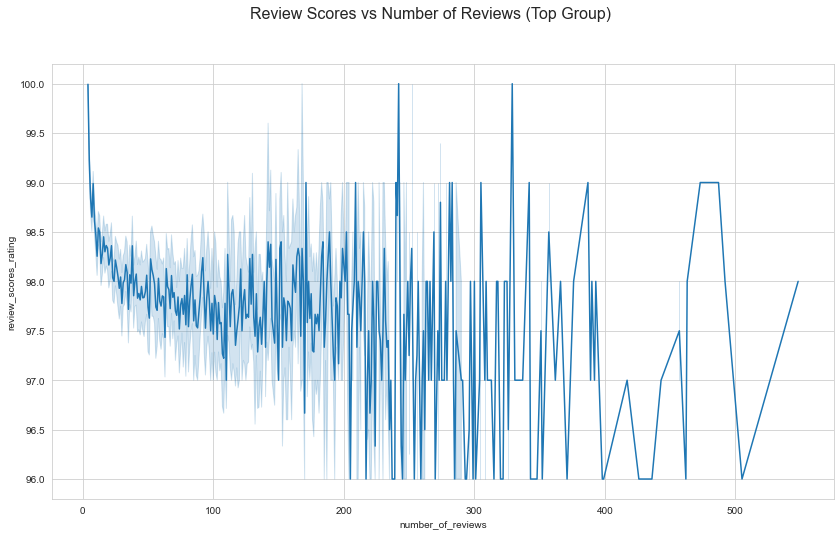

In [23]:
# An interesting observation: 
# Variability of reviews changes enormously as the number of reviews grows.
plt.figure(figsize=(14,8))
subset = df_top[['number_of_reviews', 'review_scores_rating']].sort_values(by='number_of_reviews')
sns.lineplot(x=subset['number_of_reviews'], y=subset['review_scores_rating'])
plt.suptitle('Review Scores vs Number of Reviews (Top Group)', fontsize=16)

Text(0.5, 0.98, 'Review Scores vs Number of Reviews (Growth Group)')

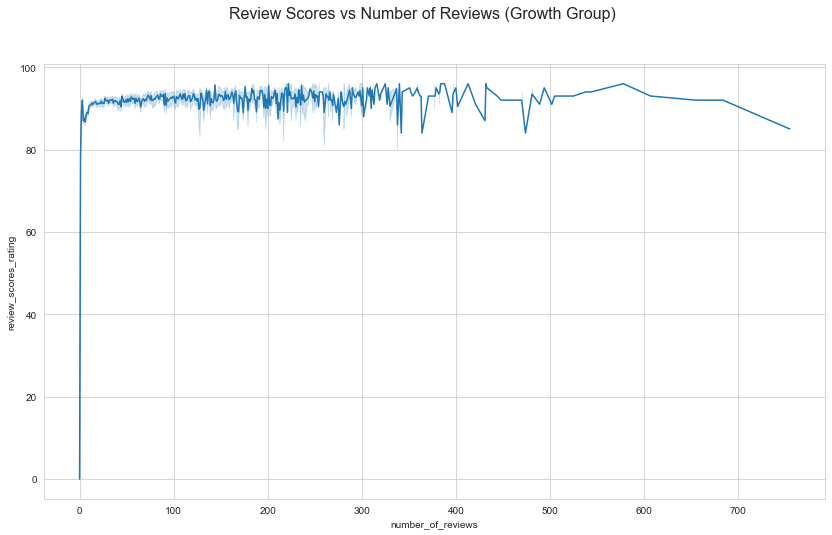

In [24]:
# Similar observation with the Growth Group. 
plt.figure(figsize=(14,8))
subset = df_lower[['number_of_reviews', 'review_scores_rating']].sort_values(by='number_of_reviews')
sns.lineplot(x=subset['number_of_reviews'], y=subset['review_scores_rating'])
plt.suptitle('Review Scores vs Number of Reviews (Growth Group)', fontsize=16)

<h2><center>1. What is word difference between listing titles in the two groups?</center></h2>

In [26]:
top_names_75 = get_top_words(df_top, 'name', 150)
top_names_25 = get_top_words(df_lower, 'name', 150)

unique_top, unique_lower = get_diff(top_names_75, top_names_25)
unique_top, unique_lower

(['patio',
  'greene',
  'peaceful',
  'block',
  'entrance',
  'flat',
  'designer',
  'clinton',
  'luxurious',
  'deck',
  'guest',
  'artist',
  'l',
  'friendly',
  'beach',
  'retreat'],
 ['master',
  'crown',
  'bedrooms',
  'beds',
  'double',
  'doorman',
  'street',
  'access',
  'th',
  'available',
  'hells',
  'furnished',
  'ave',
  'gym',
  'neighborhood',
  'blueground'])

<h2><center>1.2 Should you use all capitals in your title?</center></h2>

In [27]:
count_top = np.sum(df_top['name_is_all_caps']) / df_top.shape[0]
count_lower = np.sum(df_lower['name_is_all_caps']) / df_lower.shape[0]
print(f'Percent of top listing having title in all caps: {100 * np.round(count_top, 4)}%', )
print(f'Percent of lower-rated listings having titles in all caps: {100 * np.round(count_lower, 4)}%')

Percent of top listing having title in all caps: 2.29%
Percent of lower-rated listings having titles in all caps: 3.25%


In [28]:
df_lower[['number_of_reviews', 'name_is_all_caps']].corr()

,number_of_reviews,name_is_all_caps
number_of_reviews,1.000000,0.018303
name_is_all_caps,0.018303,1.000000


In [29]:
df_top[['number_of_reviews', 'name_is_all_caps']].corr()

,number_of_reviews,name_is_all_caps
number_of_reviews,1.000000,0.012096
name_is_all_caps,0.012096,1.000000


<h2><center>2.1 What is word difference between listing descriptions in the two groups?</center></h2>

In [30]:
top_description_75 = get_top_words(df_top, 'description', 300)
top_description_25 = get_top_words(df_lower, 'description', 300)

unique_top_description, unique_lower_description = get_diff(top_description_75, top_description_25)
unique_top_description, unique_lower_description

(['refrigerator',
  'stove',
  'decorated',
  'harlem',
  'original',
  'duplex',
  'express',
  'see',
  'townhouse',
  'water',
  'airport',
  'airbnb',
  'set',
  'sleep',
  'island',
  'level',
  'jfk',
  'fridge',
  'deck',
  'suite',
  'ft',
  'couple',
  'sq',
  'king',
  'privacy',
  'solo'],
 ['gorgeous',
  'district',
  'state',
  'outside',
  'description',
  'keep',
  'apartments',
  'doorman',
  'cleaning',
  'offers',
  'unique',
  'bushwick',
  'exposed',
  'rent',
  'prime',
  'comes',
  'lot',
  'sheets',
  'upon',
  'designed',
  'included',
  'tons',
  'im',
  'include',
  'service',
  'gym'])

<h2><center>2.2 What is word difference between neighborhood overviews in the two groups?</center></h2>

In [31]:
top_neighborhood_overview_75 = get_top_words(df_top, 'neighborhood_overview', 300)
top_neighborhood_overview_25 = get_top_words(df_lower, 'neighborhood_overview', 300)

unique_top_neighborhood_overview, unique_lower_neighborhood_overview = get_diff(top_neighborhood_overview_75, top_neighborhood_overview_25)
unique_top_neighborhood_overview, unique_lower_neighborhood_overview

(['chinese',
  'us',
  'pharmacy',
  'brooklyns',
  'deli',
  'free',
  'excellent',
  'tree',
  'now',
  'american',
  'brownstone',
  'jfk',
  'yet',
  'farmers',
  'movie',
  'ferry',
  'delicious',
  'barclays',
  'caribbean',
  'lined',
  'available',
  'laundry',
  'neighbors',
  'parking',
  'bronx',
  'mexican',
  'bay',
  'beach',
  'check',
  'delis'],
 ['view',
  'mibr',
  'high',
  'bustling',
  'cuisine',
  'eateries',
  'outside',
  'iconic',
  'hall',
  'nd',
  'professionals',
  'top',
  'starbucks',
  'bank',
  'empire',
  'surrounded',
  'airport',
  'rockefeller',
  'theaters',
  'riverside',
  'spot',
  'situated',
  'always',
  'banks',
  'space',
  'hells',
  'stroll',
  'looking',
  'residents',
  'town'])

<h2><center>3. How do Amenities differ in the two groups? </center></h2>

In [32]:
# select a subset of the data
df_amenities = new_york_listings_2021.iloc[:, 72:162]

df_lower_idx = df_lower[['id']]
df_top_idx = df_top[['id']]

# merge with two groups
amenities_lower = pd.merge(df_lower_idx, df_amenities, left_index=True, right_index=True, how='left')
amenities_higher = pd.merge(df_top_idx, df_amenities, left_index=True, right_index=True, how='left')

amenities_lower.drop(columns=['id'], inplace=True)
amenities_higher.drop(columns=['id'], inplace=True)

df_amenities_grouped = pd.DataFrame([
    np.sum(amenities_lower).sort_values(ascending=False),
    np.sum(amenities_higher).sort_values(ascending=False)
])

df_amenities_grouped['Percentile'] = ['Remaining 75%', 'Top 25%']
df_amenities_grouped.set_index('Percentile', inplace=True)
df_amenities_grouped

,wifi,heating,air conditioning,dryer,dedicated workspace,iron,hair dryer,washer,street parking,dishwasher,...,room service,housekeeping,self-parking,outdoor shower,minibar,slippers,kitchenette,body wash,stovetop,jacuzzi
Percentile,,,,,,,,,,,,,,,,,,,,,
Remaining 75%,26724.0,25708.0,22976.0,20271.0,16800.0,16057.0,15950.0,12637.0,7767.0,4137.0,...,15.0,12.0,10.0,10.0,9.0,8.0,5.0,1.0,1.0,0.0
Top 25%,9157.0,8976.0,8425.0,8055.0,6899.0,6905.0,7315.0,4878.0,5536.0,2532.0,...,0.0,0.0,0.0,6.0,0.0,0.0,1.0,1.0,1.0,0.0


In [33]:
# convert to percentages
df_amenities_grouped.loc['Remaining 75%'] = df_amenities_grouped.loc['Remaining 75%'] / df_lower.shape[0]
df_amenities_grouped.loc['Top 25%'] = df_amenities_grouped.loc['Top 25%'] / df_top.shape[0]

# drop columns that have both values == 0
for col in df_amenities_grouped.columns:
    if np.sum(df_amenities_grouped[col]) < 0.01:
        df_amenities_grouped.drop(col, axis = 1, inplace = True)
        

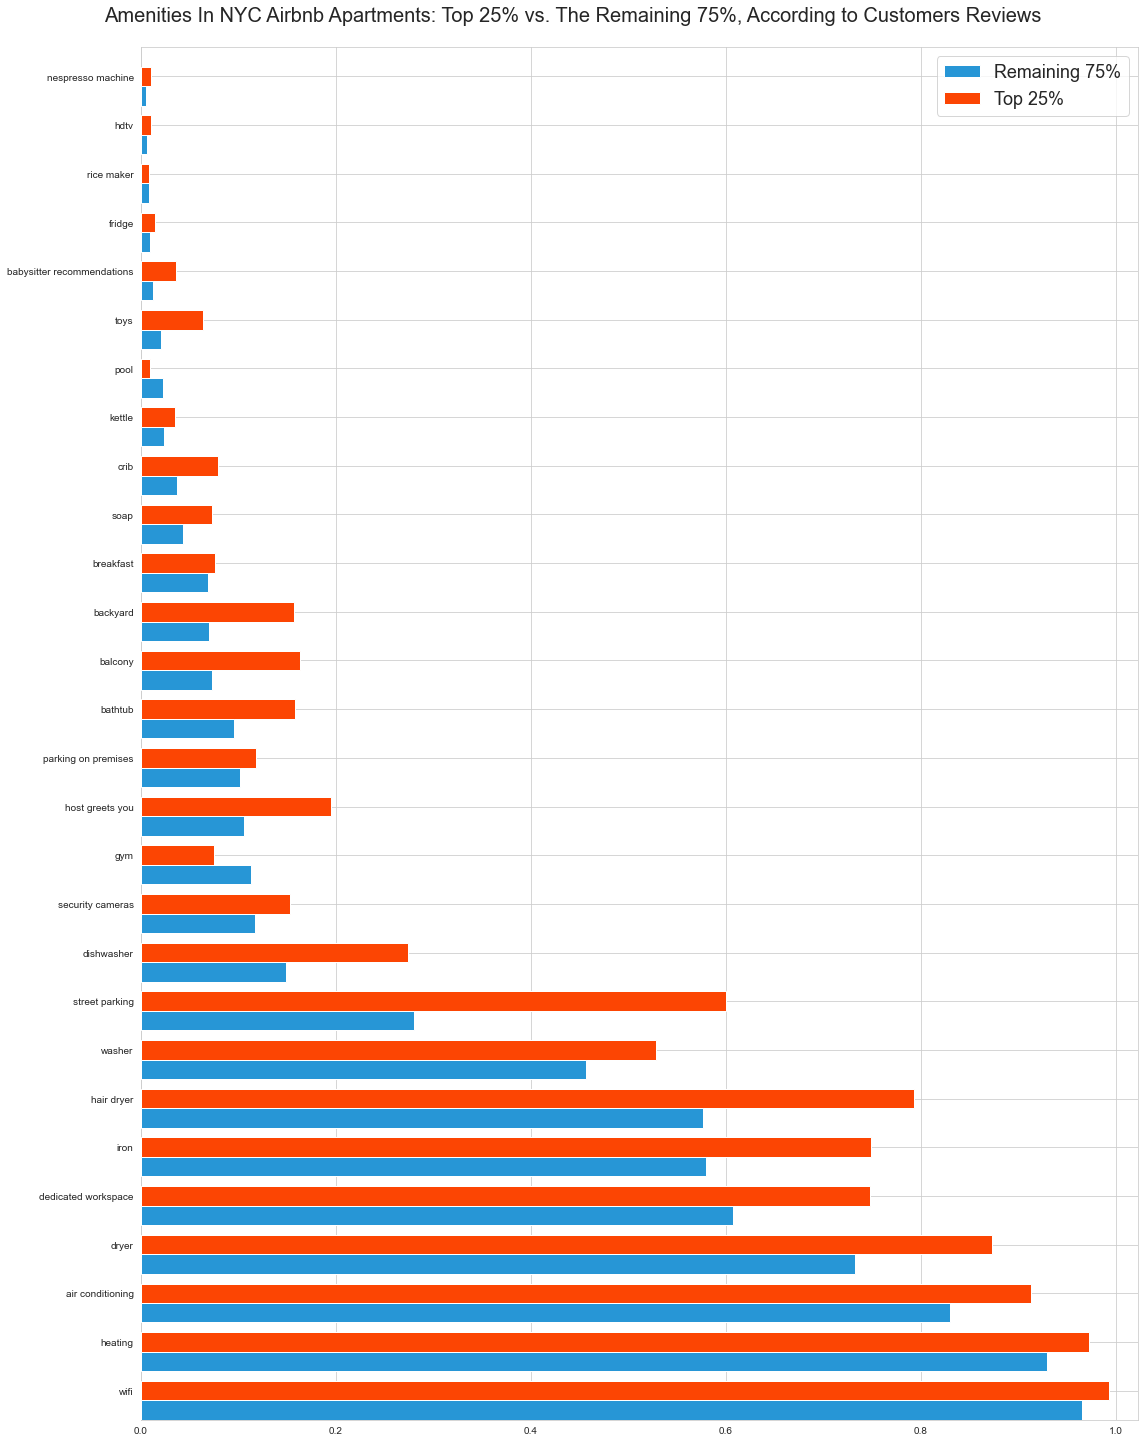

In [42]:
# build the visualization
y = df_amenities_grouped.columns

ind = np.arange(len(df_amenities_grouped.columns))
width = 0.4

fig, ax = plt.subplots(figsize=(16, 20))
ax.barh(ind, df_amenities_grouped.loc['Remaining 75%'].tolist(), width, align='center', color='#2796d6', zorder=10, label='Remaining 75%')
ax.barh(ind+width, df_amenities_grouped.loc['Top 25%'].tolist(), width, color='#fc4503', zorder=5, label='Top 25%',)

fig.suptitle('Amenities In NYC Airbnb Apartments: Top 25% vs. The Remaining 75%, According to Customers Reviews', 
             fontsize=20,
             y=1)
ax.set(yticks=ind + width, yticklabels=df_amenities_grouped.columns, ylim=[2*width - 1, len(df_amenities_grouped.columns)])

ax.margins(0.03)
ax.legend(prop={'size': 18})

fig.tight_layout()
fig.subplots_adjust(wspace=0.1)
plt.savefig('../images/amenities.png')
plt.show()

We can see that overall, listings in the top group offer more amenities than the growth group. Some of these are low cost amenities while others are more expensive. 

In [35]:
diff_df = pd.DataFrame([df_amenities_grouped.loc['Top 25%'] - df_amenities_grouped.loc['Remaining 75%']], index=['Difference'])
df_amenities_grouped = pd.concat([df_amenities_grouped, diff_df])
df_amenities_grouped_T = df_amenities_grouped.T

In [36]:
df_amenities_grouped_T = df_amenities_grouped_T.sort_values(by='Difference', ascending=False)
df_amenities_grouped_T

,Remaining 75%,Top 25%,Difference
street parking,0.280620,0.599978,0.319358
hair dryer,0.576270,0.792782,0.216512
iron,0.580136,0.748347,0.168211
dedicated workspace,0.606980,0.747697,0.140717
dryer,0.732387,0.872981,0.140595
dishwasher,0.149469,0.274412,0.124943
balcony,0.073235,0.163108,0.089873
host greets you,0.105752,0.195405,0.089653
backyard,0.069875,0.156931,0.087056
air conditioning,0.830118,0.913081,0.082963


<h2><center>4. What is word difference between host sections in the two groups?</center></h2>

In [37]:
top_host_about_75 = get_top_words(df_top, 'host_about', 300)
top_host_about_25 = get_top_words(df_lower, 'host_about', 300)

unique_top_host_about, unique_lower_host_about = get_diff(top_host_about_75, top_host_about_25)
unique_top_host_about, unique_lower_host_about

(['passionate',
  'photographer',
  'island',
  'last',
  'traveled',
  'nature',
  'film',
  'writer',
  'director',
  'hard',
  'loving',
  'europe',
  'spend',
  'italy',
  'perfect',
  'learn',
  'side',
  'welcoming',
  'williamsburg',
  'culture',
  'motto',
  'open',
  'experiences',
  'musician',
  'part',
  'staying',
  'village',
  'book',
  'dog',
  'comfort',
  'grew',
  'english',
  'keep',
  'passion',
  'management',
  'movies',
  'children',
  'wonderful',
  'along',
  'bit',
  'pretty',
  'walking',
  'street',
  'opportunity',
  'son',
  'international',
  'spanish',
  'never',
  'france',
  'california',
  'wife',
  'bedroom',
  'guy',
  'recently',
  'heart',
  'yoga',
  'leave',
  'school',
  's',
  'treat',
  'arts',
  'kids',
  'teacher',
  'read',
  'everyone',
  'small',
  'reading',
  'sure',
  'learning',
  'college',
  'worked',
  'couple',
  'full',
  'lives',
  'interesting',
  'french',
  'without',
  'especially',
  'respect',
  'spending',
  'far',
  'p

<h1><center>5. What can we learn from guest reviews?</center></h1>

In [38]:
columns = ['Cleanliness', 'Accuracy', 'Checkin', 'Value', 'Communication']

top_25 = [np.mean(
    df_top['review_scores_cleanliness']),
          np.mean(df_top['review_scores_accuracy']),
          np.mean(df_top['review_scores_checkin']),
          np.mean(df_top['review_scores_value']),
          np.mean(df_top['review_scores_communication'])
         ]
remain_75 = [np.mean(
    df_lower['review_scores_cleanliness']),
             np.mean(df_lower['review_scores_accuracy']),
             np.mean(df_lower['review_scores_checkin']),
             np.mean(df_lower['review_scores_value']),
             np.mean(df_lower['review_scores_communication'])
         ]
df_reviews = pd.DataFrame(np.array([top_25, remain_75]), columns=columns, index=['Top 25%', 'Remaining 75%'])
df_reviews

,Cleanliness,Accuracy,Checkin,Value,Communication
Top 25%,9.787363,9.951664,9.956107,9.813157,9.971822
Remaining 75%,5.604849,5.843233,5.967339,5.681408,5.959571


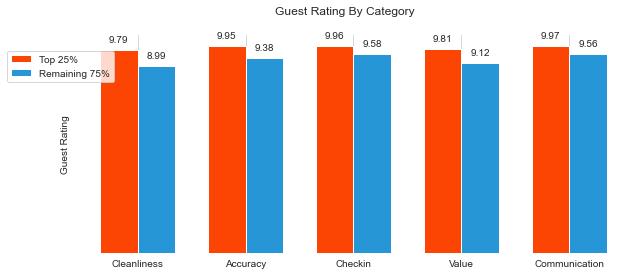

In [43]:
x = np.arange(len(columns))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 4))

rects1 = ax.bar(x - width/2, top_25, width, label='Top 25%', color='#fc4503')
rects2 = ax.bar(x + width/2, remain_75, width, label='Remaining 75%', color='#2796d6')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Guest Rating')
plt.suptitle('Guest Rating By Category')
ax.set_xticks(x)
ax.set_xticklabels(columns)

plt.legend(bbox_to_anchor=(0.08, 0.95), loc='upper right', ncol=1)

label_each_bar([ax])
ax.get_yaxis().set_ticks([])

for spine in ax.spines.values():
    spine.set_visible(False)

plt.savefig('../images/reviews.png')

plt.show()


We can see that places without any ratings significantly influence mean values of the growth group. Let's see who this graph would look like if we wouldn't take into account places with no rating

In [40]:
columns_reviews = ['review_scores_cleanliness',
                   'review_scores_accuracy',
                   'review_scores_checkin',
                   'review_scores_value',
                   'review_scores_communication'
                  ]

df_lower_reduced = df_lower

for col in columns_reviews:
    df_lower_reduced = df_lower_reduced[df_lower_reduced[col] > 0]

# df_lower_reduced = df_lower[df_lower['review_scores_cleanliness'] > 0]
# df_lower_reduced = df_lower_reduced[df_lower_reduced['review_scores_accuracy'] > 0]
# df_lower_reduced = df_lower_reduced[df_lower_reduced['review_scores_checkin'] > 0]
# df_lower_reduced = df_lower_reduced[df_lower_reduced['review_scores_value'] > 0]
# df_lower_reduced = df_lower_reduced[df_lower_reduced['review_scores_communication'] > 0]


top_25 = [np.mean(
    df_top['review_scores_cleanliness']),
          np.mean(df_top['review_scores_accuracy']),
          np.mean(df_top['review_scores_checkin']),
          np.mean(df_top['review_scores_value']),
          np.mean(df_top['review_scores_communication'])
         ]
remain_75 = [np.mean(
    df_lower_reduced['review_scores_cleanliness']),
             np.mean(df_lower_reduced['review_scores_accuracy']),
             np.mean(df_lower_reduced['review_scores_checkin']),
             np.mean(df_lower_reduced['review_scores_value']),
             np.mean(df_lower_reduced['review_scores_communication'])
         ]
df_reviews = pd.DataFrame(np.array([top_25, remain_75]), columns=columns, index=['Top 25%', 'Remaining 75%'])
df_reviews

,Cleanliness,Accuracy,Checkin,Value,Communication
Top 25%,9.787363,9.951664,9.956107,9.813157,9.971822
Remaining 75%,8.989901,9.377619,9.581752,9.123222,9.562192


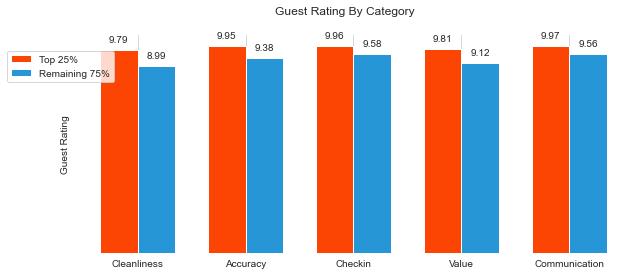

In [44]:
x = np.arange(len(columns))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 4))

rects1 = ax.bar(x - width/2, top_25, width, label='Top 25%', color='#fc4503')
rects2 = ax.bar(x + width/2, remain_75, width, label='Remaining 75%', color='#2796d6')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Guest Rating')
plt.suptitle('Guest Rating By Category')
ax.set_xticks(x)
ax.set_xticklabels(columns)

plt.legend(bbox_to_anchor=(0.08, 0.95), loc='upper right', ncol=1)

label_each_bar([ax])
ax.get_yaxis().set_ticks([])

for spine in ax.spines.values():
    spine.set_visible(False)

plt.savefig('../images/reviews2.png')

plt.show()


After we dropped listings that have no reviews, **Cleanliness** remained the lowest-rated category among all. It signifies the necessity of prioritizing this category for those interested in increasing their overall rating.


Future work: 
- Combine this dataset with data from other cities;
- Analyze guest reviews;
- Analyze and try to predict prices;
- Find more interesting insights. 